In [1]:
import tensorflow as tf 
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pydicom
import cv2
import scipy
import random


plt.style.use(['seaborn-notebook'])
# plt.style.use(['seaborn-dark'])

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync)) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3


In [2]:
BATCH_SIZE_PER_REPLICA = 3
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCH = 300

RECORDS_DIR = 'tf_records'

train_record_path = os.path.join(RECORDS_DIR, f'train.tfrecords')
valid_record_path = os.path.join(RECORDS_DIR, f'valid.tfrecords') 

In [3]:
def decode_example(example):
    img = tf.io.decode_raw(example['img'], out_type=tf.float32)
    mask = tf.io.decode_raw(example['mask'], out_type=tf.float32)
    h = example['h']
    w = example['w']

    img = tf.reshape(img, [h, w, 3])
    mask = tf.reshape(mask, [h, w, 1])
    return img, mask

In [4]:
def read_tfrecord(example):
    tfrecord_format = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'h': tf.io.FixedLenFeature([], tf.int64),
        'w': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_example = tf.io.parse_single_example(example, tfrecord_format)

    img, mask = decode_example(parsed_example)

    return img, mask

In [5]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed

    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files

    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order

    dataset = dataset.map(
        read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    return dataset

In [6]:
def flip_horizontal(image, mask):
    new_image = tf.image.flip_left_right(image)
    new_mask = tf.image.flip_left_right(mask)
    return new_image, new_mask


def flip_vertical(image, mask):
    new_image = tf.image.flip_up_down(image)
    new_mask = tf.image.flip_up_down(mask)
    return new_image, new_mask


def brighten(image, mask):
    delta = random.uniform(-0.99, 0.99)
    new_image = tf.image.adjust_brightness(image, delta)
    new_mask = mask
    return new_image, new_mask


def standardize_reshape(image, mask, img_channel=3, mask_channel=1):
#     print(f'standardize_reshape image shape: {image.shape}')
#     print(f'standardize_reshape mask shape: {mask.shape}')
    new_image = tf.reshape(image, [512, 512, img_channel])
    new_image = tf.image.per_image_standardization(new_image)
    new_mask = tf.where(mask>=0.6, 1.0, 0.0)
    new_mask = tf.reshape(new_mask, [512, 512, mask_channel])
    return new_image, new_mask


def split_img_mask(img_mask, img_channel=3, mask_channel=1):
    new_image = img_mask[:,:,:, :img_channel]
    new_image = tf.reshape(new_image, [512, 512, img_channel])
    
    new_mask = img_mask[:,:,:, img_channel:]
    new_mask = tf.where(new_mask>=0.5, 1.0, 0.0)
    new_mask = tf.reshape(new_mask, [512, 512, mask_channel])
    
    return new_image, new_mask
    

# def random_rotation(image, mask):
#     rr = tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)
#     image = tf.reshape(image, [1, 512, 512, 1])
#     mask = tf.reshape(mask, [1, 512, 512, 1])
    
#     temp = tf.concat([image, mask], axis=-1)
#     new_image, new_mask = z[:,:,:, :image.shape[-1]], z[:,:,:,image.shape[-1]:]
    
#     new_image = tf.reshape(new_image, [512, 512, 1])
#     new_mask = tf.reshape(new_mask, [512, 512, 1])
    
#     new_mask = tf.where(new_mask >= 0.6, 1, 0)
#     return new_image, new_mask
# #     return tf.convert_to_tensor(new_image, dtype=tf.float32), tf.convert_to_tensor(new_mask, dtype=tf.float32)



def py_shift(image, mask):
#     print(f'py_shift image shape: {image.shape}')
#     print(f'py_shift mask shape: {mask.shape}')
    x_shift = random.uniform(-30, 30)
    y_shift = random.uniform(-30, 30)
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    new_img = cv2.warpAffine(image, M, (512, 512))
    new_mask = cv2.warpAffine(mask, M, (512, 512))
    new_mask = np.where(new_mask >= 0.6, 1.0, 0.0)
    
    new_img = new_img.reshape(512, 512, 1)
    new_mask = new_mask.reshape(512, 512, 1)
    
    return np.ndarray.astype(new_img, np.float32), np.ndarray.astype(new_mask, np.float32)


def py_rotate(image, mask):
#     print(f'py_rotate image shape: {image.shape}')
#     print(f'py_rotate mask shape: {mask.shape}')

#     print('Rotate Start')
    rotate_axis = random.uniform(-30, 30)
    new_img = scipy.ndimage.rotate(image, rotate_axis, reshape=False)
    new_mask = scipy.ndimage.rotate(mask, rotate_axis, reshape=False)
    new_mask = np.where(new_mask >= 0.5, 1.0, 0.0)
#     print('Rotate End')
    return np.ndarray.astype(new_img, np.float32), np.ndarray.astype(new_mask, np.float32)


def py_blur(image, mask):
#     print(f'py_blur image shape: {image.shape}')
#     print(f'py_blur mask shape: {mask.shape}')

#     print('Blur Start')
    new_img = cv2.GaussianBlur(image, (5,5),0)
    new_mask = mask
    
    new_img = new_img.reshape(512, 512, 1)
    new_mask = new_mask.reshape(512, 512, 1)
    return np.ndarray.astype(new_img, np.float32), np.ndarray.astype(new_mask, np.float32)


def py_zoom(image, mask):
#     print(f'py_zoom start image shape: {image.shape}')
#     print(f'py_zoom start mask shape: {mask.shape}')

#     print('Zoom Start')
    h, w = image.shape[:2]
#     print(h, w)
    zoom_factor= round(random.uniform(1.0, 1.5), 1)
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (image.ndim - 2)
#     print(f'zoom_tuple: {zoom_tuple}')

    zh = int(np.round(h / zoom_factor))
    zw = int(np.round(w / zoom_factor))
    top = (h - zh) // 2
    left = (w - zw) // 2

    out = scipy.ndimage.zoom(image[top:top+zh, left:left+zw, :], zoom_tuple)
    out_mask = scipy.ndimage.zoom(mask[top:top+zh, left:left+zw, :], zoom_tuple)

#     print(f'py_zoom out shape: {out.shape}')
#     print(f'py_zoom out_mask shape: {out_mask.shape}')
    trim_top = ((out.shape[0] - h) // 2)
    trim_left = ((out.shape[1] - w) // 2)
    
    new_img = out[trim_top:trim_top+h, trim_left:trim_left+w]
    new_mask = out_mask[trim_top:trim_top+h, trim_left:trim_left+w]
    new_mask = np.where(new_mask >= 0.6, 1.0, 0.0)
#     print(f'py_zoom end image shape: {new_img.shape}')
#     print(f'py_zoom end mask shape: {new_mask.shape}')
    return np.ndarray.astype(new_img, np.float32), np.ndarray.astype(new_mask, np.float32)
    

# def py_zoom(image, mask):
#     temp = tf.concat([image, mask], axis=-1)
#     z = tf.keras.preprocessing.image.random_zoom(temp, (0.6, 0.6), row_axis=0, col_axis=1, channel_axis=2)
#     new_image, new_mask = z[:,:,:image.shape[-1]], z[:,:,image.shape[-1]:]
#     new_mask = np.where(new_mask >= 0.6, 1, 0)
#     return tf.convert_to_tensor(new_image, dtype=tf.float32), tf.convert_to_tensor(new_mask, dtype=tf.float32)
 

In [7]:
from tensorflow.keras import layers
from tensorflow.python.framework.ops import EagerTensor


def get_dataset(filenames, n_repeat, is_augmnet=False):
    dataset = load_dataset(filenames)
    dataset = dataset.repeat(n_repeat)
#     dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
    if is_augmnet:
        a = random.uniform(0, 1)
        if a >= 0.5:
            dataset = dataset.map(flip_horizontal,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

        b = random.uniform(0, 1)
        if b >= 0.5:
            zoom_layer = tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.4, 0.0), width_factor=(-0.4, 0.0))
            dataset = dataset.map(lambda x, y: zoom_layer(tf.concat([tf.reshape(x, [1, 512, 512, 3]), tf.reshape(y, [1, 512, 512, 1])], axis=-1)),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
            dataset = dataset.map(split_img_mask,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

        c = random.uniform(0, 1)
        if c >= 0.5:
            rotate_layer = tf.keras.layers.experimental.preprocessing.RandomRotation((-0.2, 0.2))
            dataset = dataset.map(lambda x, y: rotate_layer(tf.concat([tf.reshape(x, [1, 512, 512, 3]), tf.reshape(y, [1, 512, 512, 1])], axis=-1)),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
            dataset = dataset.map(split_img_mask,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
#         d = random.uniform(0, 1)
#         if d >= 0.5:
#             dataset = dataset.map(lambda x, y: tf.numpy_function(py_blur, [x, y], [tf.float32, tf.float32]))

#         e = random.uniform(0, 1)
#         if e >= 0.5:
#             dataset = dataset.map(lambda x, y: tf.numpy_function(py_zoom, [x, y], [tf.float32, tf.float32]))

#     norm_layer = tf.keras.layers.experimental.preprocessing.Normalization(mean=480.0, variance=(480.0)**2)
#     dataset = dataset.map(lambda x, y: (tf.reshape(x, [512, 512, 1]), tf.reshape(y, [512, 512, 1])))

#     rescale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/2048.0)
#     dataset = dataset.map(lambda x, y: (rescale_layer(x), y))
#     dataset = dataset.map(lambda x, y: (norm_layer(x), tf.cast(y, tf.float32)))

    dataset = dataset.map(standardize_reshape, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(512)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [8]:
with strategy.scope():

    train_dataset = get_dataset(train_record_path, 8, True)
    valid_dataset = get_dataset(valid_record_path, 1, False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


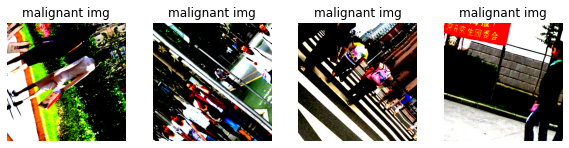

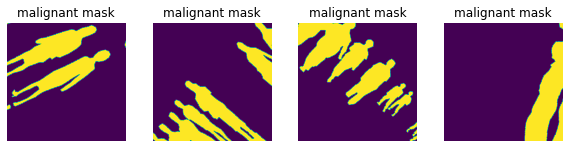

In [9]:
with strategy.scope():
#     plt.style.use(['Solarize_Light2'])
    img, mask = next(iter(train_dataset))

    def show_batch(image_batch, mask_batch):
        plt.figure(figsize=(10, 10))
        for n in range(4):
            ax = plt.subplot(4, 4, n+1)
            plt.imshow(image_batch[n])
            plt.title("malignant img")
            plt.axis("off")

        plt.figure(figsize=(10, 10))
        for n in range(4):
            ax = plt.subplot(4, 4, n+1)
            plt.imshow(mask_batch[n])
            plt.title("malignant mask")
            plt.axis("off")

    show_batch(img.numpy(), mask.numpy()) 

In [10]:
np.array(img[0]).mean(), np.array(img[0]).std()

(9.934107e-08, 0.99999994)

In [11]:
np.unique(mask[0])

array([0., 1.], dtype=float32)

In [12]:
img[0].shape, mask[0].shape

(TensorShape([512, 512, 3]), TensorShape([512, 512, 1]))

# Define loss and metric, and build model

In [25]:
class DiceBCELoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(DiceBCELoss, self).__init__(**kwargs)


    def call(self, y_true, y_pred):
#         y_pred_ = tf.convert_to_tensor(y_pred)
#         y_true_ = tf.cast(y_true, y_pred.dtype)
        smooth = 1e-3
        y_pred = tf.clip_by_value(y_pred, clip_value_min=smooth, clip_value_max=1-smooth)
        
        reduce_axis = [1,2,3] if len(y_true.shape) == 4 else [1,2]
        
        numerator = 2 * tf.math.reduce_sum(tf.math.multiply(y_true, y_pred), axis=reduce_axis) + smooth
        denominator = tf.math.reduce_sum(tf.math.add(y_true, y_pred), axis=reduce_axis) + smooth
        dice_loss = tf.math.reduce_mean(1 - tf.math.truediv(numerator, denominator))
        
        bce_ob = tf.keras.losses.BinaryCrossentropy(from_logits=False,
                                                    label_smoothing=0.2,
                                                    reduction=tf.keras.losses.Reduction.NONE)
        my_bce_loss = tf.reduce_mean(bce_ob(y_true, y_pred))
        
        return dice_loss + my_bce_loss

In [26]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='IoU'):
        super(MyMeanIOU, self).__init__(num_classes=num_classes, name=name)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred>=0.5, y_true.dtype)
        return super().update_state(y_true, y_pred, sample_weight)

In [27]:
from unet import make_unet


with strategy.scope():
    model = make_unet()
    model.summary()
    
#     dice_bce_loss = DiceBCELoss()

    auc = tf.keras.metrics.AUC(name='AUC')
    bin_acc = tf.keras.metrics.BinaryAccuracy()
#     mIoU = tf.keras.metrics.MeanIoU(2, name='mIoU')
    mIoU = MyMeanIOU(2)
    
    initial_learning_rate = 0.01
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipvalue=5.0),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.2),
#                   loss=dice_bce_loss,
                  metrics=[auc,
                           mIoU,
                           bin_acc]) 

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block_18 (ConvBlock)       (None, None, None, 6 39232       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, None, None, 6 0           conv_block_18[0][0]              
__________________________________________________________________________________________________
conv_block_19 (ConvBlock)       (None, None, None, 1 222464      max_pooling2d_8[0][0]            
_______________________________________________________________________________________________

In [28]:
import datetime


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10, decay_rate=0.5, staircase=True
)

checkpoint_path = f"saved_models/bce_unet" + "_epoch{epoch:03d}-valAUC{val_AUC:.2f}-valIoU{val_IoU:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_AUC',
#     mode='max',
    verbose=1,
#     save_best_only=True,
    save_weights_only=True
)

# iou_checkpoint_path = f"../saved_models/bce_unet_{DISEASE_NAME}" + "_{epoch:04d}-{val_IoU:.2f}.ckpt"
# iou_checkpoint_dir = os.path.dirname(iou_checkpoint_path)

# iou_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#     filepath=iou_checkpoint_path,
#     monitor='val_IoU',
#     mode='max',
#     verbose=1,
#     save_best_only=True,
#     save_weights_only=True
# )


early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_AUC',
    patience=20, restore_best_weights=True
)

log_dir = f"tensorboard_logs/bce_unet/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
with strategy.scope():
    model.fit(
        train_dataset,
        epochs=EPOCH,
        validation_data=valid_dataset,
        callbacks=[
            checkpoint_cb,
#             iou_checkpoint_cb,
            early_stopping_cb,
            tensorboard_cb
        ],
    )


Epoch 1/300
INFO:tensorflow:batch_all_reduce: 84 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 84 all-reduces with algorithm = nccl, num_packs = 1
91/91 [==============================] - 56s 382ms/step - loss: 0.6499 - AUC: 0.6782 - IoU: 0.4256 - binary_accuracy: 0.7572 - val_loss: 0.6996 - val_AUC: 0.4984 - val_IoU: 0.1016 - val_binary_accuracy: 0.2026

Epoch 00001: saving model to saved_models/bce_unet_epoch001-valAUC0.50-valIoU0.10.ckpt
Epoch 2/300
15/91 [===>..........................] - ETA: 22s - loss: 0.5243 - AUC: 0.8305 - IoU: 0.5829 - binary_accuracy: 0.8098